In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree, Delaunay
from numba         import njit

In [2]:
ndim    = 1
npoints = 50
nnbs    = 5

In [3]:
# xs         = np.random.rand(npoints, ndim)
xs         = np.array([np.logspace(-2, 1, npoints)]).T
# xs         = np.array([np.linspace(0, 1, npoints)]).T
KDTree     = cKDTree(xs)
delaunay   = Delaunay(xs)
dists, ids = KDTree.query(xs, nnbs+1)
hs         = np.sqrt(np.mean(dists[:,1:]**2, axis=1))

ValueError: Need at least 2-D data

In [4]:
@njit
def smooth(i1, i2, hs):
    h1 = hs[i1]**2
    h2 = hs[i2]**2
    return (h1 + h2)/(h1 * h2)

In [5]:
@njit
def kernel(i1, i2, hs):
    r = xs[i1] - xs[i2]
    d = np.dot(r,r)
    return np.exp(-d*smooth(i1, i2, hs))

In [6]:
@njit
def grad2_kernel(i1, i2, hs, grad_hs):
    
    a1 = 1.0 / hs[i1]**2
    a2 = 1.0 / hs[i2]**2

    rr = xs[i1] - xs[i2]

    ff = 1.0 + np.dot(rr, grad_hs[i2]/hs[i2])
    
    return rr * (a1 + a2*ff) * kernel(i1, i2, hs)

The following is a "smooth" way to define the local element size distribution
\begin{equation}
    h(x_i)^2 \ = \
    \frac{\sum_{j} ( x_i - x_j )^2 \ k(x_i, x_j) }
         {\sum_{j}                   k(x_i, x_j) }.
\end{equation}
However, it is recusrively defined, since $k$ depends on $h$, but can be (recursively) computed.

In [7]:
@njit
def max_relative_difference(a, b):
    return 2.0*np.max(np.abs((a - b)/(a + b)))

In [8]:
@njit
def recompute_hs(hs):
    
    h_new = np.zeros(npoints)
    
    for i in range(npoints):
        norm = 0.0
        for (j, dist) in zip(ids[i][1:], dists[i][1:]):
            kern      = kernel(i, j, hs)
            norm     += kern
            h_new[i] += kern * dist**2
        h_new[i] /= norm
    
    h_new = np.sqrt(h_new)
    
    print('max relative change =', max_relative_difference(hs, h_new))
    
    return h_new

In [9]:
for i in range(20):
    hs = recompute_hs(hs)

max relative change = 0.4972771345255995
max relative change = 0.3515361333280706
max relative change = 0.2362170073674853
max relative change = 0.08687912527764435
max relative change = 0.03947509574882385
max relative change = 0.01532598387924326
max relative change = 0.007657718425655312
max relative change = 0.0034623924333318165
max relative change = 0.0017485089921771269
max relative change = 0.0008563512560465091
max relative change = 0.0004125994751000302
max relative change = 0.00019748212115662858
max relative change = 9.429238278185955e-05
max relative change = 4.498508397008028e-05
max relative change = 2.1454124756662654e-05
max relative change = 1.0228983996471064e-05
max relative change = 5.189811928522613e-06
max relative change = 2.9512967468880262e-06
max relative change = 1.849573895664547e-06
max relative change = 1.159106254210473e-06


Computing the gradient based on nearest neighbor information based on Meyer, Eriksson, and Maggio (2001).
For a point at position $\textbf{x}_{i}$, and nearest neighbors $\textbf{x}_{j}$, we can observe that
\begin{equation}
f_{j} - f_{i} \ = \ \left(\textbf{x}_{j} - \textbf{x}_{i} \right) \cdot \nabla f_{i}
\end{equation}

\begin{equation}
\Delta f \ = \ \Delta \textbf{x}^{\text{T}} \nabla f
\end{equation}

\begin{equation}
\nabla f \ = \
\left( \Delta \textbf{x}^{\text{T}} \Delta \textbf{x} \right)^{-1} \ \Delta \textbf{x}^{\text{T}} \Delta f
\end{equation}

In [10]:
def get_grad_hs(hs):

    grad_hs = np.zeros((npoints, ndim))
    
    for i in range(npoints):
        nbs = ids[i][1:]
        dx  = xs[i] - xs[nbs]
        dh  = hs[i] - hs[nbs]
        grad_hs[i] = np.matmul(np.linalg.inv(np.matmul(dx.T, dx)), np.matmul(dx.T, dh))
    
    return grad_hs

In [11]:
grad_hs = get_grad_hs(hs)

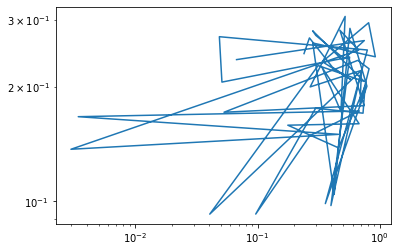

In [12]:
plt.plot(xs[:,0], hs)
plt.xscale('log')
plt.yscale('log')

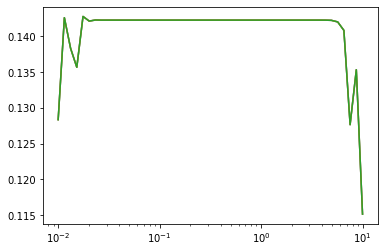

In [34]:
plt.plot(xs[:,0], grad_hs)
plt.xscale('log')
# plt.yscale('log')

In [19]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

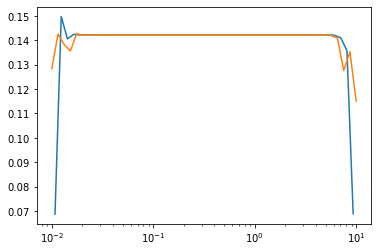

In [20]:
x, y = diff(xs[:,0], hs)

plt.plot(x, y)
plt.plot(xs[:,0], grad_hs)
plt.xscale('log')
# plt.yscale('log')

In [17]:
delaunay.vertex_neighbor_vertices

(array([  0,  14,  26,  34,  48,  63,  80,  89, 103, 120, 133, 145, 156,
        164, 176, 188, 197, 210, 223, 237, 247, 260, 273, 287, 299, 311,
        322, 332, 340, 353, 362, 372, 383, 396, 408, 421, 435, 448, 459,
        469, 483, 494, 506, 520, 528, 543, 550, 562, 576, 583, 592],
       dtype=int32),
 array([19, 47, 28, 11, 24, 25, 44, 41, 14, 42, 12, 13, 20,  7, 32, 43, 15,
        11, 27, 17, 25, 24,  8,  9,  5, 46, 45, 16, 37, 36, 47, 29,  8, 34,
        32, 35, 40, 17, 38, 13, 42, 20, 41, 18, 33, 21, 26,  5,  8, 29, 31,
         9,  5, 47, 10, 39, 18, 14, 21, 22, 37, 34,  6,  3, 32, 35,  9, 18,
        17,  1, 21, 27, 26, 38, 49, 31,  8,  4, 46,  6,  4, 22, 18,  5,  9,
        35, 34, 23,  8, 17, 24, 25, 20, 38, 27, 48, 26, 39, 21, 13,  0, 46,
        49, 36, 15, 11, 31, 30, 47, 29, 25, 49,  1,  9,  2,  5,  4, 46, 34,
         6, 23, 32, 15,  1,  8, 22, 35,  5, 31,  4, 46, 34,  6, 14, 19, 33,
        47, 37, 31, 30, 39, 42, 12, 18,  4, 24,  0, 25, 44, 28, 43, 36, 15,
       